In [1]:
import numpy as np
import tensorflow as tf
# next line only for Colab
%tensorflow_version 2.x
# import tensorflow-datasets to be able to access the tensorflow inbuilt datasets
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## 1. Load the Dataset

In [2]:
training_data = tfds.load("malaria", split="train[:80%]", as_supervised=True)
test_data = tfds.load("malaria", split="train[-20%:]", as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteEOS3OW/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


### Plotting exemplary images with their shapes



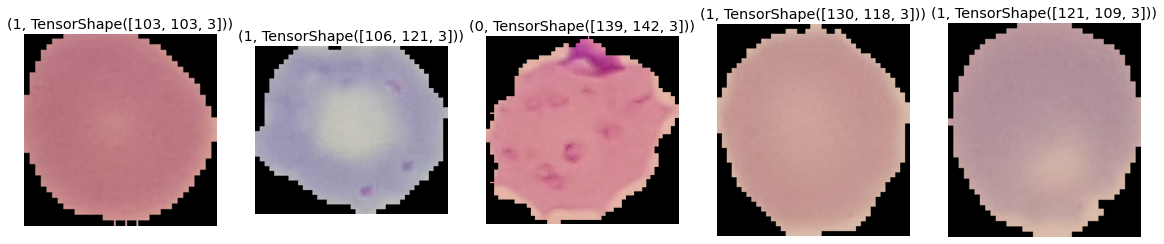

In [59]:
# Plotting the first 5 images in our training data -> all of them have different shapes
fig, ax = plt.subplots(1,5, figsize = (20,20))

for i, (image,label) in enumerate(training_data):
  img = image
  lbl = label.numpy(), image.shape 
  ax[i].imshow(img)
  ax[i].set_title(lbl)
  ax[i].axis("off")
  if i >= 4:
    break

## In case one needs to obtain the smallest dimension over all images in order to downscale the dataset.
```
print(np.min([i.shape[0:2] for i,_ in training_data]))
print(np.min([i.shape[0:2] for i,_ in test_data]))
```


In [5]:
# extract the maximum and minimum pixel value such that we can normalize our data 
print("Maximum Pixel value for the trainings data: ", np.max([np.max(i.numpy()) for i,_ in training_data]))
print("Maximum Pixel value for the test data: ", np.max([np.max(i.numpy()) for i,_ in test_data]))
print("Minimum Pixel value for the trainings data: ", np.min([np.min(i.numpy()) for i,_ in training_data]))
print("Minimum Pixel value for the test data: ", np.min([np.min(i.numpy()) for i,_ in test_data]))

Maximum Pixel value for the trainings data:  255
Maximum Pixel value for the test data:  255
Minimum Pixel value for the trainings data:  0
Minimum Pixel value for the test data:  0


### Data Pipeline where every Datapoint is loaded into RAM

In [6]:
# resize the images to 64x64 but keep the original ratio of each image
images_train = [tf.image.resize_with_pad(image, 64, 64)/255.0 for image,_ in training_data]
labels_train = [label for _,label in training_data]
images_test = [tf.image.resize_with_pad(image, 64, 64)/255.0 for image,_ in test_data]
labels_test = [label for _,label in test_data]

In [41]:
# Create tensorflow Datasets from train images and labels respectively
train_dataset_img = tf.data.Dataset.from_tensor_slices(images_train)
train_dataset_labels = tf.data.Dataset.from_tensor_slices(labels_train)

# onehot encode the target label using 2 digits representing the one of the two classes
train_dataset_labels = train_dataset_labels.map(lambda t : tf.one_hot(t, 2))
 
# zip together the freshly created Datasets ((input, label) pairs)
train_dataset = tf.data.Dataset.zip((train_dataset_img, train_dataset_labels))

# shuffle, batch and prefetch the zipped dataset, everytime we access train_dataset it will be reshuffled (decreases chance of overfitting)
train_dataset = train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(20)
 
# repeat the process for our test data
test_dataset_img = tf.data.Dataset.from_tensor_slices(images_test)
test_dataset_labels = tf.data.Dataset.from_tensor_slices(labels_test)
test_dataset_labels = test_dataset_labels.map(lambda t : tf.one_hot(t, 2))
 
test_dataset = tf.data.Dataset.zip((test_dataset_img, test_dataset_labels))
test_dataset = test_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.prefetch(20)

### Alternative Data Pipeline where data isn't loaded into RAM (prolonged training time)

```
malaria_train, malaria_test = tfds.load("malaria", split=["train[:80%]", "train[-20%:]"], shuffle_files=True, as_supervised=True)

train_dataset = malaria_train.map(lambda img, lbl : (tf.image.resize_with_pad(img, 40, 40)/255.0, tf.one_hot(lbl, 2)))
train_dataset = train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(10)

test_dataset = malaria_test.map(lambda img, lbl : (tf.image.resize_with_pad(img, 40, 40)/255.0, tf.one_hot(lbl, 2)))
test_dataset = test_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.prefetch(10)
```


### Plotting to confirm that the resizing worked

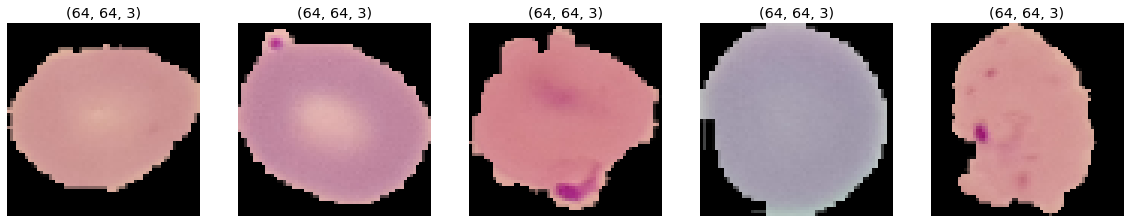

In [79]:
# All images have the same shape now
fig, ax = plt.subplots(1,5, figsize = (20,20))

for i, entry in enumerate(train_dataset):
  img = entry[0][i]
  lbl = entry[0][i].shape
 
  ax[i].imshow(img)
  ax[i].set_title(lbl)
  ax[i].axis("off")
  if i >= 4:
    break

## 2. Model

In [9]:
# We will implement a CNN

# Our network will have the following layers:
# Input : 64x64x3 images
# Convolutional layer 1: filters = 32 , kernel_size = 5, strides = (1,1), padding = "valid",  activation = relu
# Convolutional layer 2: filters = 64 , kernel_size = 5, strides = (1,1), padding = "valid",  activation = relu
# Max Pool layer 3: pool_size = (2,2), strides = (2,2)
# Convolutional layer 4: filters = 128 , kernel_size = 5, strides = (1,1), padding = "valid",  activation = relu
# Global Max Pool layer 5: takes max values from each feature map
# Output Layer: 2 units. With softmax activation function.

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    """Class for creating a Neural Network which inherits from the Model class from keras 
    """

    def __init__(self):
      """Initialize a network with a variable amount of keras.Layers
      """
      # use the keyword super to allow our network to access the init() form the keras Model class
      super(Model, self).__init__()

      # Define the layers structure.
      self.conv_layer_1 = tf.keras.layers.Conv2D(filters = 32 , kernel_size = 5, strides = (1,1), padding = "valid",  activation = tf.keras.activations.relu, input_shape = (64,64,3))
      self.conv_layer_2 = tf.keras.layers.Conv2D(filters = 64 , kernel_size = 5, strides = (1,1), padding = "valid",  activation  = tf.keras.activations.relu)
      self.maxPool_layer_3 = tf.keras.layers.MaxPool2D(pool_size =(2,2), strides = (2,2))
      self.conv_layer_4 = tf.keras.layers.Conv2D(filters = 128 , kernel_size = 5, strides = (1,1), padding = "valid",  activation = tf.keras.activations.relu)
      self.globPool_layer_5 = tf.keras.layers.GlobalMaxPooling2D() 
      self.output_layer = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)
        
    # use the decorator @tf.function to speed up the model call    
    @tf.function    
    def call(self, x):
      """Activate our model propagating the input through the network layer by layer

      Arguments:
        x (Tensor): Tensor containing the input to our network

      Returns:
        x (Tensor): Tensor containing the probabilities for the two classes
      """
      x = self.conv_layer_1(x)
      x = self.conv_layer_2(x)
      x = self.maxPool_layer_3(x)
      x = self.conv_layer_4(x)
      x = self.globPool_layer_5(x)
      x = self.output_layer(x)
      return x
  

## 3. Training 

In [10]:
def train_step(model, input, target, loss_function, optimizer):
  """Perform a training step for a given Neural Network by
  1. Propagating the input through the network
  2. Calculating the loss between the networks output and the true targets 
  2. Performing Backpropagation and Updating the trainable variables witht the calculated gradients 
 
  Arguments:
    model (Model): given instance of an initialised Neural Network with all its parameters
    input (EagerTensor): Tensor containing the input data 
    target (EagerTensor): Tensor containing the respective targets 
    loss_function (keras.losses): function from keras to calculate the loss
    optimizer (keras.optimizers): function from keras defining the to be applied optimizer during learning 
 
  Returns:
    loss (EagerTensor): Tensor containing the loss of the Network 
  """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    # 1.
    prediction = model(input)
    # 2.
    loss = loss_function(target, prediction)
    # 3.
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
 
  return loss 
 
def test(model, test_data, loss_function):
  """Tests the models accuracy and loss over the given data set with a given loss_function
 
  Arguments:
    model (Model): given instance of an initialised Neural Network with all its parameters
    test_data (Dataset): test dataset to test the NN on 
    loss_function (keras.losses): function from keras to calculate the loss 
 
  Returns:
    test_loss (float): Average loss of the Neural Network over the test set
    test_accuracy (float): Average accuray of the Neural Network over the test set
  """
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []
  
  for (input, target) in test_data:
    prediction = model(input)
    
    # calculates the loss value (as a tensors) for an entire batch 
    sample_test_loss = loss_function(target, prediction)
 
    # creates a boolean array of dimension (100,) for each batch 
    # each entry represents whether one (sequence, label) pair was predicted correctly 
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
 
    # take the mean over each boolean array to obtain the average accuracy for one batch 
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
 
    # append the mean of all batch accuracies  
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
 
  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)
 
  return test_loss, test_accuracy

In [42]:
tf.keras.backend.clear_session()
 
### Hyperparameters
num_epochs = 34
learning_rate = 0.001
running_average_factor = 0.95
 
# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(learning_rate)
# Initialize the optimizer: Adam with default parameters.
optimizer = tf.keras.optimizers.Adam()
 
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []
 
# testing once before we begin on the test data
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
 
# check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)
 
# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
 
    # training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)
 
    # testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
 
    _, train_accuracy = test(model, train_dataset, cross_entropy_loss)
    train_accuracies.append(train_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25
Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29
Epoch: __ 30
Epoch: __ 31
Epoch: __ 32
Epoch: __ 33


In [14]:
# Overview of the models parameters
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  2432      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  204928    
_________________________________________________________________
global_max_pooling2d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  258       
Total params: 258,882
Trainable params: 258,882
Non-trainable params: 0
_______________________________________________________

## 4. Visualization

Text(15, 0.8, 'final test accuracy 95.72%')

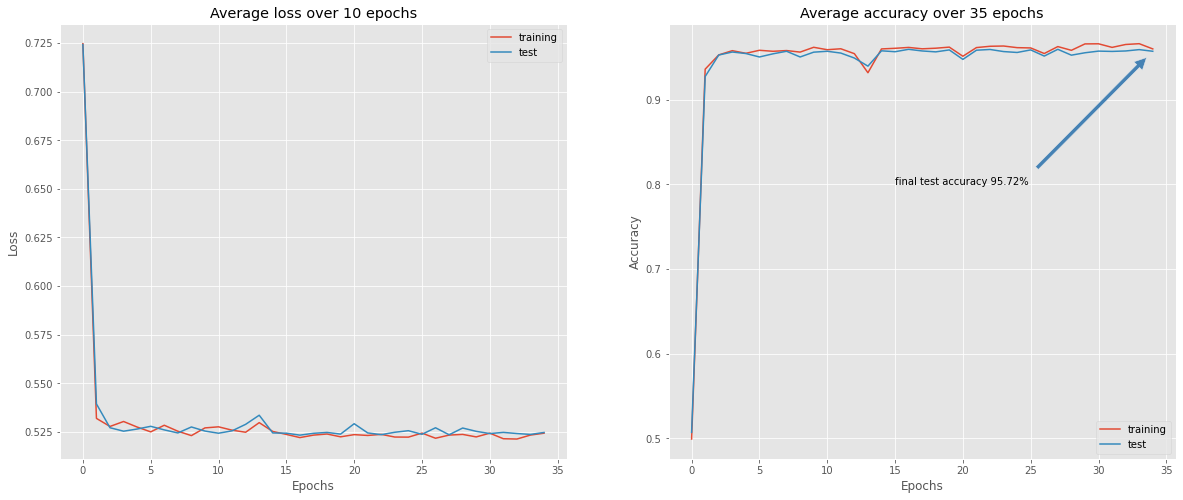

In [40]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
 
# change the style of the plots to a nicer theme
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))
 
# plot for average loss
ax[0].plot(train_losses, label='training')
ax[0].plot(test_losses, label='test')
ax[0].set(ylabel='Loss', xlabel='Epochs', title='Average loss over 34 epochs')
ax[0].legend()
 
# plot for average accuracy, with annotation for the last accuracy value on our test data 
ax[1].plot(train_accuracies, label='training')
ax[1].plot(test_accuracies, label='test')
ax[1].set(ylabel='Accuracy', xlabel='Epochs', title='Average accuracy over 34 epochs')
ax[1].legend()
ax[1].annotate(f'final test accuracy {round(test_accuracies[34], 4)*100}%', xy=(34, test_accuracies[34]), xytext=(15, 0.8),
            arrowprops=dict(facecolor='steelblue', shrink=0.05))

## Overview of all train and test accuracies

In [53]:
train_accuracies

[0.5007105009633912,
 0.9498615125240848,
 0.956590197495183,
 0.9580352842003854,
 0.9604287090558767,
 0.9564667630057804,
 0.9612987716763006,
 0.9592094171483623,
 0.9599078757225434,
 0.9588481454720617,
 0.9572344653179191,
 0.9580804431599229,
 0.951192196531792,
 0.9608230973025048,
 0.9542088150289018,
 0.9598536849710982,
 0.9609796483622352,
 0.9639631502890174,
 0.9647519267822736,
 0.9643244219653179,
 0.9582941955684008,
 0.9613770472061657,
 0.9641437861271677,
 0.9640414258188825,
 0.9550999518304432,
 0.9645050578034682,
 0.9582490366088632,
 0.9623133429672447,
 0.9633760838150289,
 0.9598868015414258,
 0.9645953757225434,
 0.9662542148362235,
 0.9484043834296725,
 0.9673380298651253,
 0.9673049132947977]

In [54]:
test_accuracies

[0.4987571022727273,
 0.9486860795454546,
 0.9554332386363636,
 0.9559659090909091,
 0.9577414772727273,
 0.9541903409090909,
 0.958984375,
 0.9554332386363636,
 0.9586292613636364,
 0.9540127840909091,
 0.9547230113636364,
 0.9518821022727273,
 0.9495738636363636,
 0.9579190340909091,
 0.9493963068181818,
 0.9559659090909091,
 0.9549005681818182,
 0.9598721590909091,
 0.9598721590909091,
 0.955078125,
 0.9557883522727273,
 0.9579190340909091,
 0.9582741477272727,
 0.9545454545454546,
 0.9502840909090909,
 0.9598721590909091,
 0.9525923295454546,
 0.9549005681818182,
 0.95703125,
 0.9572088068181818,
 0.9586292613636364,
 0.958984375,
 0.9426491477272727,
 0.958984375,
 0.9596946022727273]